In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import sys
from tqdm import tqdm

In [3]:
from hopfield_modern.hopfield_modern import Hopfield

In [37]:
def dice_score(prediction, data) -> float:
    tp, tn, fp, fn = 0, 0, 0, 0
    for p, d in zip(prediction.flat, data.flat):
        if d>0 and p>0:
            tp += 1
        # if d<0 and p<0:
        #     tn += 1
        if d>0 and p<0:
            fn += 1
        if d<0 and p>0:
            fp += 1
  
    return 2*tp/(2*tp + fp + fn)

In [38]:
def iou_score(prediction, data) -> float:
    tp, tn, fp, fn = 0, 0, 0, 0
    for p, d in zip(prediction.flat, data.flat):
        if d>0 and p>0:
            tp += 1
        # if d<0 and p<0:
        #     tn += 1
        if d>0 and p<0:
            fn += 1
        if d<0 and p>0:
            fp += 1
  
    return tp/(tp + fp + fn)

In [39]:
def classify(image, dataset, score)-> int:
    max_i = 0
    for i in range(len(dataset)):
        sample = dataset[i]
        if score(image, sample) > score(image, dataset[max_i]):
            max_i = i
    return max_i    

In [49]:
def prepare_image_label(dataset: np.ndarray, index: np.uint, threshold=100, scale=0.6):
    image, label = dataset[index]
    image = tf.image.central_crop(image, scale)
    # image = tf.where(image>threshold, 1, 0)
    image/=255
    image = image.numpy().flatten()
    image = np.array(image, np.float32)*2-1
    
    return image, label

In [19]:
train_iter = tfds.as_numpy(tfds.load('mnist', split='train', shuffle_files=True, as_supervised=True))
dataset_train = np.fromiter(train_iter, dtype=tuple)

KeyboardInterrupt: 

In [8]:
iter_test = tfds.as_numpy(tfds.load('mnist', split='train', shuffle_files=True, as_supervised=True))
dataset_test = np.fromiter(iter_test, dtype=tuple)

In [9]:
%store dataset_train
%store dataset_test

Stored 'dataset_train' (ndarray)
Stored 'dataset_test' (ndarray)


In [7]:
%store -r

In [8]:
digits = [[] for i in range(10)]
index = 0
for d in dataset_train:
    digits[d[1]].append(index)
    index += 1

In [50]:
memory_images = []
scale = 0.6
threshold = 100
shape = ()
for digit in range(10):
    index = random.choice(digits[ digit ])
    image = tf.image.central_crop(dataset_train[index][0], scale)
    # image = tf.where(image>threshold, 1, 0)
    image/=255
    memory_images.append(image.numpy().flatten())

    
shape = tuple(image.shape)[:2]
memory_images = np.array(memory_images, dtype=np.float32)*2-1


1


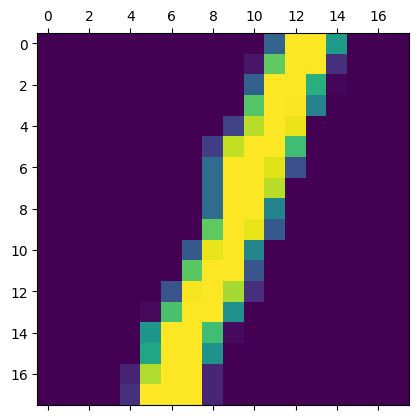

In [51]:
model = Hopfield(memory_images.T.copy())

image, label = prepare_image_label(dataset_test, 1111, threshold, scale)

output = model.run(image, 0.5)
print(label)
plt.matshow(np.resize(output, new_shape=shape))

In [52]:
test_count = 1000

result_dice = [[] for i in range(10)]
result_iou = [[] for i in range(10)]

model = Hopfield(memory_images.T.copy())
# model.train()

for index in tqdm(range(test_count)):
    image, label = dataset_test[index]
    image = tf.image.central_crop(image, scale)
    # image = tf.where(image>threshold, 1, 0)
    image /= 255
    image = image.numpy().flatten()
    image = np.array(image, np.float32)*2-1
    
    output = model.run(image, b=16.0)
    
    predicted_label_dice = classify(output, memory_images, dice_score)
    predicted_label_iou = classify(output, memory_images, iou_score)
    
    result_dice[label].append( predicted_label_dice == label )
    result_iou[label].append( predicted_label_iou == label )
    
    

100%|██████████| 1000/1000 [03:33<00:00,  4.68it/s]


In [53]:
i = 0
print("Result with Dice(F1) score classifier")
result_dice = np.array(result_dice, dtype=object)
for stat in result_dice:
    print(f"{i}: {int(sum(stat)/len(stat)*100)}%, {len(stat)} tests")
    i+=1
print(f" total: {sum([sum(i) for i in result_dice])/test_count*100}%")

i = 0
print("Result with Dice(F1) score classifier")
result_iou = np.array(result_iou, dtype=object)
for stat in result_iou:
    print(f"{i}: {int(sum(stat)/len(stat)*100)}%, {len(stat)} tests")
    i+=1
print(f" total: {sum([sum(i) for i in result_iou])/test_count*100}%")

Result with Dice(F1) score classifier
0: 55%, 84 tests
1: 85%, 109 tests
2: 26%, 100 tests
3: 26%, 96 tests
4: 13%, 113 tests
5: 34%, 85 tests
6: 46%, 92 tests
7: 51%, 94 tests
8: 8%, 112 tests
9: 13%, 115 tests
 total: 35.0%
Result with Dice(F1) score classifier
0: 55%, 84 tests
1: 85%, 109 tests
2: 26%, 100 tests
3: 26%, 96 tests
4: 13%, 113 tests
5: 34%, 85 tests
6: 46%, 92 tests
7: 51%, 94 tests
8: 8%, 112 tests
9: 13%, 115 tests
 total: 35.0%
